In [1]:
from marc_embeddings import loc
import itertools

records = list(itertools.islice(loc.load_from_xml('include/marc/BooksAll.part01.xml.frag_02'), 10000))
print("Loaded %i records" % len(records))

Loaded 10000 records


In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import kneighbors_graph
from marc_embeddings import marc

FIELDS = marc.select(marc.AllFields)

hv = HashingVectorizer(n_features = 40000, ngram_range = (1, 2), stop_words='english')
tfidf = TfidfTransformer()

vectorizer = Pipeline([
    ('features', FeatureUnion(
        list(map(lambda field: (field, Pipeline([
            ('read xml', loc.LOCTransformer([field])),
            ('flatten', loc.FlattenTransformer()),
            ('hash, tf-idf', Pipeline([
                ('hash', hv),
                ('tf-idf', tfidf)
            ]))
        ])), FIELDS))
    )),
    ('reduce dimensions', TruncatedSVD(300)),
    ('normalize to unit value', Normalizer(copy = False))
])

X = vectorizer.fit_transform(records)

In [3]:
ward = AgglomerativeClustering(
    linkage = 'ward',
    n_clusters = 10,
    connectivity = kneighbors_graph(X, n_neighbors = 8, include_self = False))

kmeans = MiniBatchKMeans(
    n_clusters = 10,
    init = 'k-means++')

model = Pipeline([
    ('cluster', kmeans)
])

model.fit(X)

Pipeline(memory=None,
     steps=[('cluster', MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0))])

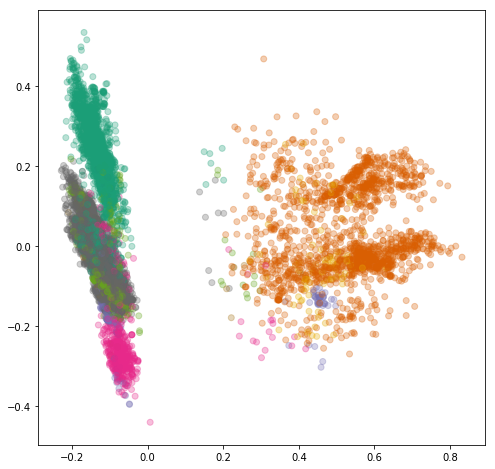

In [4]:
# Visualize the records in two dimensions with PCA, color by cluster.

%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_pca = PCA(2).fit_transform(X)

plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = kmeans.labels_, cmap = 'Dark2', alpha = 0.3)